# Training a Graph-structured GAN for Floor Plan Auto-Completion

## Imports and config

In [1]:
# general
import os
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch_geometric as pyg
from torch_geometric.loader import DataLoader
from torch_snippets import subplots, print  # this overwrites the common print (!)
from omegaconf import OmegaConf

# own
from utils import load_pickle

# configurations
cfg = OmegaConf.load("config.yaml")
print(OmegaConf.to_yaml(cfg))

seed: 0
opt:
  optimizer: Adam
  momentum: 0.9
  weight_decay: 0.0001
  lr: 0.001
  betas: (0.5, 0.999)
model:
  name: tag_conv
  framework: gan
  noise_size: 128
  gen_hids_size: (64, 32, 32)
  gen_out_size: 5
  dis_hids_size: (64, 32, 16)
  n_critic: 5
  lambda_gp: 10
train:
  start_epoch: 0
  epochs: 50
  bs: 32
eval: null
dataset:
  path: C:\Users\caspervanengel\OneDrive\Documents\PHD\1_data\swiss-dwellings\3.0.0\cvaad-challenge
  ratio: 0.8
  max_polygons: 30
  num_workers: 4
wandb:
  log: true
  dir: ./
  name: tag-conv-gan
  entity: casper-van-engelenburg
  project: floor-plan-auto-completion
misc: null

## Data factory

In [2]:
# set paths
path = {
    "full": cfg.dataset.path,
    "graph": os.path.join(cfg.dataset.path, 'train', 'graph_out'),
    "graph_simple": os.path.join(cfg.dataset.path, 'train', 'graph_simple')
}

# check path existence
_ = [print(f'{path[key]} exists: {os.path.exists(path[key])}') for key in path.keys()]

C:\Users\caspervanengel\OneDrive\Documents\PHD\1_data\swiss-dwellings\3.0.0\cvaad-challenge exists: True

C:\Users\caspervanengel\OneDrive\Documents\PHD\1_data\swiss-dwellings\3.0.0\cvaad-challenge\train\graph_out exists:
True

C:\Users\caspervanengel\OneDrive\Documents\PHD\1_data\swiss-dwellings\3.0.0\cvaad-challenge\train\graph_simple 
exists: True

### Change graphs to simple graphs / and filter on max polygons

In [3]:
# from tqdm.auto import tqdm
#
# # helper functions
# def get_max_size_polygon(areas):
#
#     max_points = 0
#     for area in areas:
#         temp_points = len(area)
#         if temp_points > max_points:
#             max_points = temp_points
#
#     return max_points
#
# # get polygon size distribution
# polygon_size_distribution = []
# for file in tqdm(os.listdir(path["graph"])):
#
#     # extract index from file
#     index = file[:-7]
#     graph_nx = load_pickle(os.path.join(path["graph"], f'{index}.pickle'))
#
#     # extract geometries
#     areas = [n for _, n in graph_nx.nodes(data="geometry")]
#
#     # get largest polygon
#     max_size = get_max_size_polygon(areas)
#     polygon_size_distribution.append(max_size)

In [4]:
# from collections import Counter, defaultdict
# import matplotlib.pyplot as plt
#
# # count polygon number
# count_df = dict(Counter(polygon_size_distribution))
# print(len(count_df.values()))
#
# # histogram
# fs = 10
# fig, ax = plt.subplots(1,1,figsize=(fs, fs))
#
# _ = plt.hist(count_df, bins=len(count_df.values()))
# # print(count_df.columns)
# # count_df = count_df.sort_values(by = )

### New data instances (room properties)

In [5]:
import networkx as nx
from shapely.geometry import Polygon, Point
import math
import numpy as np
from tqdm.auto import tqdm

def _azimuth(point1, point2):
    """azimuth between 2 points (interval 0 - 180)"""

    angle = np.arctan2(point2[0] - point1[0], point2[1] - point1[1])
    return np.degrees(angle) if angle > 0 else np.degrees(angle) + 180

def _dist(a, b):
    """distance between points"""

    return math.hypot(b[0] - a[0], b[1] - a[1])

def get_properties(polygon):
    """azimuth of minimum_rotated_rectangle"""

    xy = list(polygon.centroid.coords)[0]

    # extract bbox
    bbox = list(polygon.minimum_rotated_rectangle.exterior.coords)

    # determine width and height
    width = _dist(bbox[0], bbox[3])
    height = _dist(bbox[0], bbox[1])

    # determine area
    # area = width * height

    # to make consistent
    if width <= height:
        az = _azimuth(bbox[0], bbox[1])
    else:
        az = _azimuth(bbox[0], bbox[3])

    return torch.tensor([xy[0], xy[1], width, height, np.radians(az)])

# for file in tqdm(os.listdir(path["graph"])):
#
#     # extract index from file
#     index = file[:-7]
#     graph_nx = load_pickle(os.path.join(path["graph"], f'{index}.pickle'))
#
#     info_nodes = {}
#     for n, area in graph_nx.nodes(data="geometry"):
#
#         # convert to polygon
#         polygon = Polygon(area)
#
#         # get minimum rotated rectangle around it
#         info = get_properties(polygon)
#
#         # add information to dictionary
#         info_nodes[n] = {"properties": info}
#
#     # add information to graph and convert to pyg graph
#     graph_nx.add_nodes_from([(u, v) for u, v in info_nodes.items()])
#     graph_pyg = pyg.utils.from_networkx(graph_nx)
#
#     # delete unnecessary information
#     del graph_pyg.geometry
#     del graph_pyg.centroid
#     del graph_pyg.connectivity
#
#     torch.save(graph_pyg, os.path.join(path["graph_simple"], f'{index}'))

In [6]:
graph_pyg = torch.load(os.path.join(path["graph_simple"], f'{456}'))
print(graph_pyg)
print(graph_pyg.properties[1])

Data(edge_index=[2, 34], room_type=[18], properties=[18, 5], num_nodes=18)

tensor[5] f64 x∈[1.283, 5.750] μ=3.037 σ=1.737 [5.750, 3.545, 2.685, 1.920, 1.283]

### Plot graphs

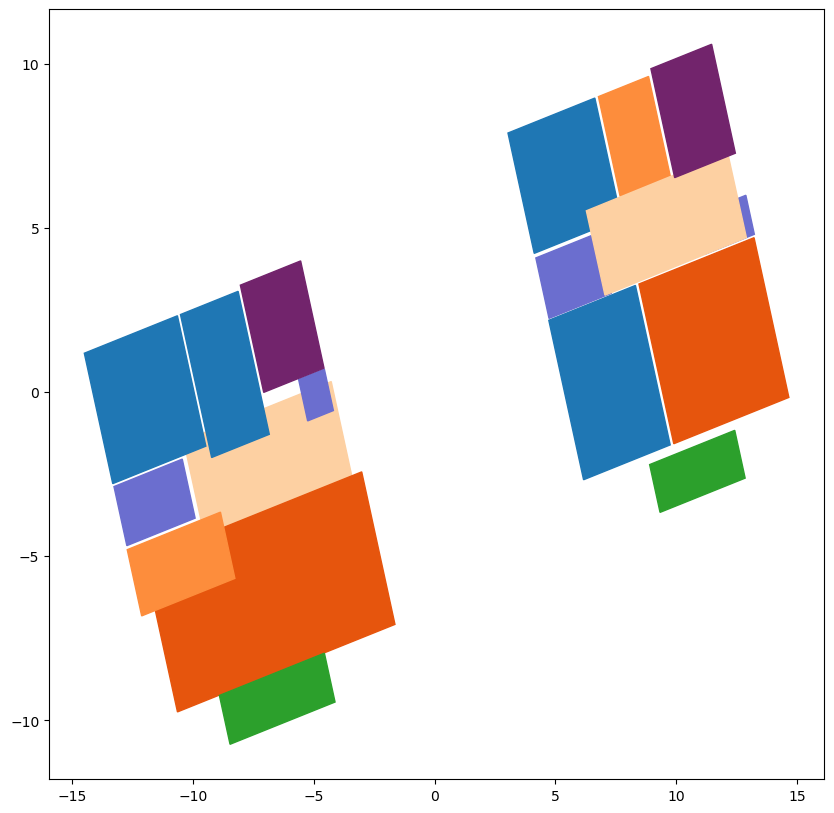

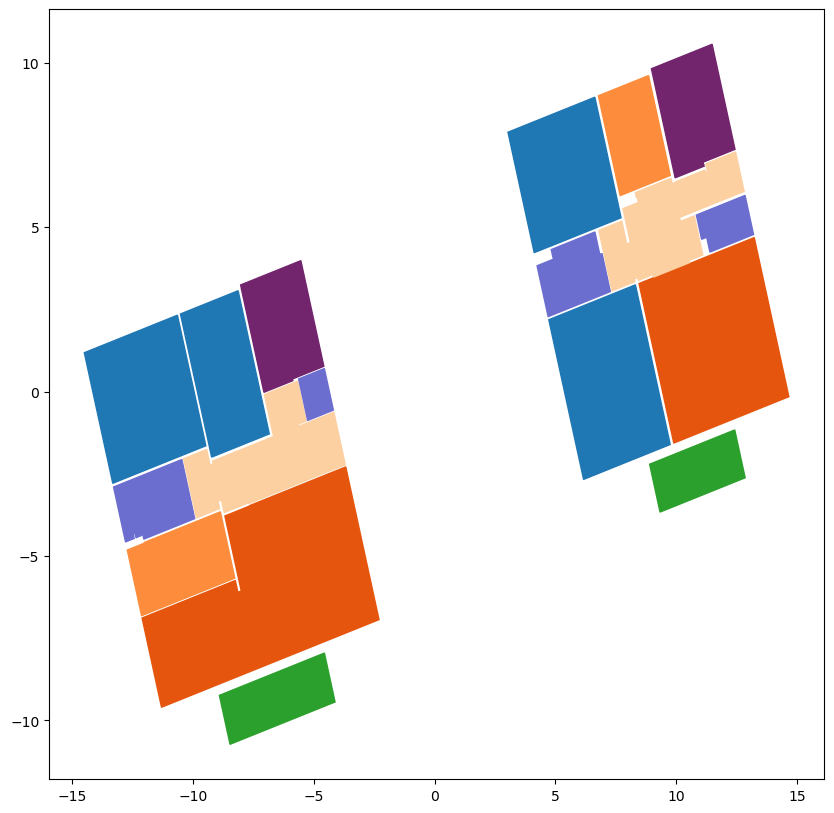

In [7]:
from shapely import affinity
from shapely.geometry import Polygon
from constants import CMAP_ROOMTYPE
from plot import plot_polygon

def info_to_geom(info):  # torch.tensor([xy[0], xy[1], width, height, np.radians(az)])

    c_x, c_y, w, h, rot = info
    xmin = c_x - 1/2 * w
    xmax = c_x + 1/2 * w
    ymin = c_y - 1/2 * h
    ymax = c_y + 1/2 * h

    diff_x = xmax - xmin
    diff_y = ymax - ymin

    rect = Polygon([[xmin, ymin], [xmin, ymax], [xmax, ymax], [xmax, ymin]])
    if diff_x < diff_y:
        rot_rect = affinity.rotate(rect, np.degrees(-rot), 'center')
    else:
        rot_rect = affinity.rotate(rect, np.degrees(-rot) + 90, 'center')

    return rot_rect

graph_pyg = torch.load(os.path.join(path["graph_simple"], f'{456}'))

# set up figure
fs = 10
fig, ax = plt.subplots(1,1,figsize=(fs, fs))

for info, roomtype in zip(graph_pyg.properties, graph_pyg.room_type):

    geom = info_to_geom(info)

    c=np.array(CMAP_ROOMTYPE(roomtype)).reshape(1,4)
    plot_polygon(ax, geom, fc=c, ec=c, label=c)


graph_nx = load_pickle(os.path.join(path["graph"], f'{456}.pickle'))
graph_pyg = pyg.utils.from_networkx(graph_nx)

# set up figure
fs = 10
fig, ax = plt.subplots(1,1,figsize=(fs, fs))

for geom, roomtype in zip(graph_pyg.geometry, graph_pyg.room_type):

    geom = Polygon(geom)

    c=np.array(CMAP_ROOMTYPE(roomtype)).reshape(1,4)
    plot_polygon(ax, geom, fc=c, ec=c, label=c)

### Develop custom graph dataset / dataloader

In [8]:
# import random
# from utils import save_pickle
#
# # size of full dataset
# N = len(os.listdir(path["graph_simple"]))
# ids = np.arange(0, N-1)
#
# # randomly shuffle ids
# random.Random(4).shuffle(ids)
#
# # split training and test
# split = 0.75
# N_train = int(split*N)
#
# print(f"Total:\t{N}")
# print(f'Samples:\n\ttrain:\t{N_train}\n\tval:\t{N - N_train}')
#
# split = {
#     "train": np.sort(ids[:N_train]),
#     "test": np.sort(ids[N_train:])
# }
#
# save_pickle(split, './split.pickle')

In [9]:
from constants import COLORS_ROOMTYPE
import torch.nn.functional as F

class GraphDataset(torch.utils.data.Dataset):
    """
    Graph Dataset. Collects NetworkX graph from a pre-defined folder and
    transforms them to Pytorch Geometric (pyg.data.Data()) instances.
    """
    def __init__(self, path, mode='train'):
        self.graph_path = path["graph_simple"]
        self.ids = load_pickle('split.pickle')[mode]

        # include graph transformations if you like
        # self.graph_transform = graph_transform

    def __getitem__(self, index):

        # get correct identity
        id = self.ids[index]

        # get access graph (name is index)
        graph = torch.load(os.path.join(self.graph_path, f'{id}'))

        # make one hot vectors from room categories
        graph.category = F.one_hot(graph.room_type, num_classes=len(COLORS_ROOMTYPE))

        del graph.room_type

        # add floor plan index as graph-level attribute
        graph.index = id

        # transform graph if you like
        # graph_pyg = self.graph_transform(graph_pyg)

        return graph

    def __len__(self):
        return len(self.ids)

In [10]:
bs = 64
dataset = GraphDataset(path, mode='train')
dataloader = DataLoader(dataset, batch_size=bs, shuffle=True)

In [11]:
dataiter = iter(dataloader)
batch = next(dataiter)
print(batch)

DataBatch(edge_index=[2, 3664], properties=[1773, 5], num_nodes=1773, category=[1773, 13], index=[64], 
batch=[1773], ptr=[65])

## Training

### Set up model

Define Generator and Discriminator classes.

In [12]:
import torch.nn as nn
from torch_geometric.nn import TAGConv, global_add_pool

class Generator(nn.Module):

    """
    WGAN-GP Generator

    Goal: make Discriminator maximize its output (score)
    """

    def __init__(self, input_dim, output_dim, hidden_dims=[64, 32, 16]):
        """
        input_dim:
        outpit_dim:
        """
        super().__init__()

        self.input_dim = input_dim
        self.hidden_dims = hidden_dims
        self.output_dim = output_dim
        self.dropout_rate = 0.1

        # network layers; initial list
        self.module_list = nn.ModuleList()

        # input layer:
        self.module_list.append(TAGConv(input_dim, hidden_dims[0]))

        # intermediate layers; gradually add layers
        for i in range(1, len(hidden_dims)):
            layer = TAGConv(hidden_dims[i - 1], hidden_dims[i])
            self.module_list.append(layer)

        # Output layers
        self.module_list.append(TAGConv(hidden_dims[-1], output_dim))


    def forward(self, edge_index, x):

        # forward through modules in module list
        for module in self.module_list:
            x = module(x=x, edge_index=edge_index)
            x = nn.Dropout(self.dropout_rate, inplace=False)(x)
            x = nn.PReLU()(x)

        return x


class Discriminator(nn.Module):
    """
    WGAN-GP Discriminator
    Goal: minimize critic score for real samples
          maximize critic score for generator samples
    """
    def __init__(self, input_dim, hidden_dims=[16, 32, 64]):
        super().__init__()

        self.input_dim = input_dim
        self.hidden_dims = hidden_dims
        self.dropout_rate = 0.1
        self.act = nn.Sigmoid()

        # scalar value (score) indicating how real the input is
        # in WGAN-GP we don't use sigmoid to turn it into a probability
        self.output_dim = 1

        # network layers; initial list
        self.module_list = nn.ModuleList()

        # input layer
        self.module_list.append(TAGConv(input_dim, hidden_dims[0]))

        # intermediate layers
        for i in range(1, len(hidden_dims)):
            layer = TAGConv(hidden_dims[i - 1], hidden_dims[i])
            self.module_list.append(layer)

        # output layer
        output_layer = nn.Linear(hidden_dims[-1], 1)
        self.module_list.append(output_layer)


    def forward(self, edge_index, x, batch):

        # loop through modules of module list
        for i in range(len(self.module_list) - 1):
            x = self.module_list[i](x=x , edge_index=edge_index)
            x = nn.Dropout(self.dropout_rate, inplace=False)(x)
            x = nn.PReLU()(x)

        # Pool graph node features; only add when coming from the same data instance
        x = global_add_pool(x, batch)

        # Predict WGAN score
        x = self.module_list[-1](x)
        # x = self.act(x)

        return x

In [13]:
def gradient_penalty(discriminator, edge_index, x_dr, x_df, batch):

    assert x_dr.shape == x_df.shape, "real and fake geometry shapes dont match"

    x_dr.requires_grad = True
    #fake.geometry.requires_grad = True

    # Construct interpolated geometry/features and compute score
    N, F = x_df.shape
    alpha = torch.rand((N, 1)).repeat(1, F)
    x_interpolated = alpha * x_dr + (1 - alpha) * x_df
    #interpolated_geometry.requires_grad = True

    interpolation_score = discriminator(edge_index, x_interpolated, batch)

    # Compute gradient of interpolated score wrt interpolated features
    # Note that (inputs, outputs) linked through a function above (discriminator is our function in this case)
    gradient = torch.autograd.grad(
        inputs=x_interpolated,                            # what we compute the gradients wrt to
        outputs=interpolation_score,                             # output we want gradients of
        grad_outputs=torch.ones_like(interpolation_score),
        create_graph=True,
        retain_graph=True
    )[0]

    # Change shape so we can compute penalty over the non batch dimension
    gradient = gradient.view(gradient.shape[0], -1)
    gradient_norm = gradient.norm(2, dim=-1)

    # (norm - 1) ** 2 enforces 1 lipschitz continutiy as we aim for this value to be as small as possible (0)
    # which is only achieved when the gradient_norm = 1
    return ((gradient_norm - 1 ) ** 2).mean()


def polygon_penalty(real_geometry, fake_geometry, alpha=0.1):  #TODO: what is alpha?
    """
    Compute a penalty based on MSE distance between the real and the fake geometry coordinates
    """

    # MSE distance between real and fake
    polygon_similarity = ((real_geometry - fake_geometry) ** 2).mean()

    # TODO: Penalty for more polygons in fake compared to real data?

    return polygon_similarity

In [14]:
generator = Generator(
    input_dim = cfg.model.noise_size + len(COLORS_ROOMTYPE),
    output_dim = cfg.model.gen_out_size,
    hidden_dims = [64, 32, 16]
)

# generator = Generator(
#     input_dim = len(COLORS_ROOMTYPE),
#     output_dim = cfg.model.gen_out_size,
#     hidden_dims = [64, 32, 16]
# )

discriminator = Discriminator(
    input_dim = cfg.model.gen_out_size,
    hidden_dims = [16, 32, 64]
)

print(generator.module_list)
print(discriminator.module_list)

ModuleList(
  (0): TAGConv(141, 64, K=3)
  (1): TAGConv(64, 32, K=3)
  (2): TAGConv(32, 16, K=3)
  (3): TAGConv(16, 5, K=3)
)

ModuleList(
  (0): TAGConv(5, 16, K=3)
  (1): TAGConv(16, 32, K=3)
  (2): TAGConv(32, 64, K=3)
  (3): Linear(in_features=64, out_features=1, bias=True)
)

### Optimizer and objective

In [15]:
from torch.nn import MSELoss

# Optimizers
optimizer_g = torch.optim.Adam(generator.parameters(), lr=cfg.opt.lr, betas=(0.5, 0.999))
optimizer_d = torch.optim.Adam(discriminator.parameters(), lr=cfg.opt.lr, betas=(0.5, 0.999))

# Loss instantiation
mse_loss = MSELoss()

### Run

In [ ]:
import time
from tqdm.auto import tqdm

generator = Generator(
    input_dim = cfg.model.noise_size + len(COLORS_ROOMTYPE),
    output_dim = cfg.model.gen_out_size,
    hidden_dims = [64, 32, 16]
)

discriminator = Discriminator(
    input_dim = cfg.model.gen_out_size,
    hidden_dims = [16, 32, 64]
)

optimizer_g = torch.optim.Adam(generator.parameters(), lr=cfg.opt.lr, betas=(0.5, 0.999))
optimizer_d = torch.optim.Adam(discriminator.parameters(), lr=cfg.opt.lr, betas=(0.5, 0.999))

num_steps = 0
start_time = time.time()

for epoch in range(cfg.train.epochs):

    losses_d = []
    losses_g = []

    for data in tqdm(dataloader, total=len(dataloader)):
        num_steps += 1

        # get and define sources of information
        x_dr = data.properties.float()
        edge_index = data.edge_index
        category = data.category
        # print(category.shape, len(COLORS_ROOMTYPE))
        batch = data.batch

        # add noise and create x for generator
        noise = torch.randn((category.shape[0], cfg.model.noise_size))
        x_g = torch.concat((category, noise), dim=1)

        # feedforward through generator and create fake input for discriminator
        x_df = generator(edge_index, x_g)

        discriminator_fake = discriminator(edge_index, x_df.detach(), batch)    # discriminator scores for fakes
        discriminator_real = discriminator(edge_index, x_dr, batch)    # discriminator scores for reals

        gp = gradient_penalty(discriminator, edge_index, x_dr, x_df.detach(), batch)

        # Discriminator loss and train
        loss_discriminator = discriminator_fake.mean() - discriminator_real.mean() + cfg.model.lambda_gp * gp

        # Set gradients to zero
        #discriminator.zero_grad()
        optimizer_d.zero_grad()

        # Backprop and move
        loss_discriminator.backward()
        optimizer_d.step()

        losses_d.append(loss_discriminator.item())

        # Only train Generator every 5 steps
        if num_steps % cfg.model.n_critic == 0:

            # develop new sample
            x_df = generator(edge_index, x_g)
            discriminator_fake = discriminator(edge_index, x_df, batch)

            # loss of generator
            loss_generator = mse_loss(x_dr, x_df) - discriminator_fake.reshape(-1).mean()

            # Set gradients to zero
            # generator.zero_grad()
            optimizer_g.zero_grad()

            # Backprop and move
            loss_generator.backward()
            optimizer_g.step()

            losses_g.append(loss_generator.item())

    # 49 is just a temporary number
    epoch_time = time.time() - start_time
    start_time = time.time()
    print("Epoch {} took {:.2f} seconds.\n"
          "Loss (GEN / DIS): {:.2f} / {:.2f}".format(epoch, epoch_time, np.mean(losses_g), np.mean(losses_d)))

  0%|          | 0/49 [00:00<?, ?it/s]

Epoch 0 took 9.72 seconds.
Loss (GEN / DIS): -195.25 / -999.53

  0%|          | 0/49 [00:00<?, ?it/s]

Epoch 1 took 10.00 seconds.
Loss (GEN / DIS): -66.80 / -2261.79

  0%|          | 0/49 [00:00<?, ?it/s]

Epoch 2 took 8.24 seconds.
Loss (GEN / DIS): 30.08 / -2749.21

  0%|          | 0/49 [00:00<?, ?it/s]

Epoch 3 took 9.61 seconds.
Loss (GEN / DIS): -63.58 / -2773.77

  0%|          | 0/49 [00:00<?, ?it/s]

Epoch 4 took 8.34 seconds.
Loss (GEN / DIS): -170.51 / -2958.39

  0%|          | 0/49 [00:00<?, ?it/s]

Epoch 5 took 10.00 seconds.
Loss (GEN / DIS): -479.50 / -1870.04

  0%|          | 0/49 [00:00<?, ?it/s]

Epoch 6 took 8.68 seconds.
Loss (GEN / DIS): -167.88 / -1160.94

  0%|          | 0/49 [00:00<?, ?it/s]

Epoch 7 took 8.73 seconds.
Loss (GEN / DIS): -350.22 / -804.17

  0%|          | 0/49 [00:00<?, ?it/s]

Epoch 8 took 8.86 seconds.
Loss (GEN / DIS): -464.18 / -678.33

  0%|          | 0/49 [00:00<?, ?it/s]

Epoch 9 took 8.47 seconds.
Loss (GEN / DIS): -348.82 / -601.47

  0%|          | 0/49 [00:00<?, ?it/s]

Epoch 10 took 8.58 seconds.
Loss (GEN / DIS): -20.72 / -626.30

  0%|          | 0/49 [00:00<?, ?it/s]

Epoch 11 took 9.04 seconds.
Loss (GEN / DIS): -16.09 / -423.57

  0%|          | 0/49 [00:00<?, ?it/s]

Epoch 12 took 8.70 seconds.
Loss (GEN / DIS): -222.85 / -373.02

  0%|          | 0/49 [00:00<?, ?it/s]

Epoch 13 took 8.51 seconds.
Loss (GEN / DIS): -255.43 / -352.33

  0%|          | 0/49 [00:00<?, ?it/s]

Epoch 14 took 8.87 seconds.
Loss (GEN / DIS): 217.20 / -280.23

  0%|          | 0/49 [00:00<?, ?it/s]

Epoch 15 took 8.76 seconds.
Loss (GEN / DIS): 39.56 / -441.59

  0%|          | 0/49 [00:00<?, ?it/s]

Epoch 16 took 9.18 seconds.
Loss (GEN / DIS): 20.42 / -377.74

  0%|          | 0/49 [00:00<?, ?it/s]

Epoch 17 took 9.13 seconds.
Loss (GEN / DIS): -50.17 / -509.56

  0%|          | 0/49 [00:00<?, ?it/s]

Epoch 18 took 8.79 seconds.
Loss (GEN / DIS): 124.40 / -531.13

  0%|          | 0/49 [00:00<?, ?it/s]

Epoch 19 took 8.78 seconds.
Loss (GEN / DIS): 76.07 / -519.51

  0%|          | 0/49 [00:00<?, ?it/s]

Epoch 20 took 8.97 seconds.
Loss (GEN / DIS): 18.20 / -509.84

  0%|          | 0/49 [00:00<?, ?it/s]

Epoch 21 took 8.82 seconds.
Loss (GEN / DIS): -80.44 / -494.27

  0%|          | 0/49 [00:00<?, ?it/s]

Epoch 22 took 9.12 seconds.
Loss (GEN / DIS): -3.81 / -456.62

  0%|          | 0/49 [00:00<?, ?it/s]

Epoch 23 took 9.04 seconds.
Loss (GEN / DIS): -85.69 / -442.06

  0%|          | 0/49 [00:00<?, ?it/s]

Epoch 24 took 9.32 seconds.
Loss (GEN / DIS): -34.35 / -411.74

  0%|          | 0/49 [00:00<?, ?it/s]

Epoch 25 took 10.09 seconds.
Loss (GEN / DIS): 48.69 / -390.20

  0%|          | 0/49 [00:00<?, ?it/s]

Epoch 26 took 9.04 seconds.
Loss (GEN / DIS): -235.48 / -379.15

  0%|          | 0/49 [00:00<?, ?it/s]

Epoch 27 took 9.06 seconds.
Loss (GEN / DIS): -33.53 / -363.55

  0%|          | 0/49 [00:00<?, ?it/s]

Epoch 28 took 8.64 seconds.
Loss (GEN / DIS): -155.02 / -361.01

  0%|          | 0/49 [00:00<?, ?it/s]

Epoch 29 took 9.16 seconds.
Loss (GEN / DIS): -101.22 / -352.46

  0%|          | 0/49 [00:00<?, ?it/s]

Epoch 30 took 8.56 seconds.
Loss (GEN / DIS): -84.87 / -340.87

  0%|          | 0/49 [00:00<?, ?it/s]

Epoch 31 took 8.91 seconds.
Loss (GEN / DIS): -30.38 / -348.47

  0%|          | 0/49 [00:00<?, ?it/s]

Epoch 32 took 8.93 seconds.
Loss (GEN / DIS): -111.84 / -348.59

  0%|          | 0/49 [00:00<?, ?it/s]

Epoch 33 took 8.69 seconds.
Loss (GEN / DIS): -61.69 / -344.88

  0%|          | 0/49 [00:00<?, ?it/s]

Epoch 34 took 8.62 seconds.
Loss (GEN / DIS): -69.33 / -344.85

  0%|          | 0/49 [00:00<?, ?it/s]

Epoch 35 took 8.55 seconds.
Loss (GEN / DIS): -110.04 / -358.88

  0%|          | 0/49 [00:00<?, ?it/s]

Epoch 36 took 9.03 seconds.
Loss (GEN / DIS): -66.09 / -339.46

  0%|          | 0/49 [00:00<?, ?it/s]

Epoch 37 took 8.67 seconds.
Loss (GEN / DIS): -33.77 / -356.74

  0%|          | 0/49 [00:00<?, ?it/s]

Epoch 38 took 9.32 seconds.
Loss (GEN / DIS): -141.88 / -371.20

  0%|          | 0/49 [00:00<?, ?it/s]

Epoch 39 took 9.01 seconds.
Loss (GEN / DIS): -138.98 / -368.29

  0%|          | 0/49 [00:00<?, ?it/s]

Epoch 40 took 9.47 seconds.
Loss (GEN / DIS): -90.06 / -356.71

  0%|          | 0/49 [00:00<?, ?it/s]

Epoch 41 took 10.34 seconds.
Loss (GEN / DIS): -166.50 / -361.05

  0%|          | 0/49 [00:00<?, ?it/s]

Epoch 42 took 9.78 seconds.
Loss (GEN / DIS): -21.72 / -349.89

  0%|          | 0/49 [00:00<?, ?it/s]

Epoch 43 took 9.12 seconds.
Loss (GEN / DIS): -220.40 / -366.20

  0%|          | 0/49 [00:00<?, ?it/s]